<a href="https://colab.research.google.com/github/Krishnaa548/Genai/blob/main/conditional_GAN_generating_fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## - Import

In [ ]:
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('torch version:',torch.__version__)
print('device:', device)

torch version: 2.5.1+cu124
device: cpu


## - Parameters

In [ ]:
# Data
train_data_path = '/content/fashion-mnist_train.csv' # Path of data
valid_data_path = '/content/fashion-mnist_test.csv' # Path of data
print('Train data path:', train_data_path)
print('Valid data path:', valid_data_path)

img_size = 28 # Image size
batch_size = 64  # Batch size

# Model
z_size = 100
generator_layer_size = [256, 512, 1024]
discriminator_layer_size = [1024, 512, 256]

# Training
epochs = 30  # Train epochs
learning_rate = 1e-4

Train data path: /content/fashion-mnist_train.csv
Valid data path: /content/fashion-mnist_test.csv


## - Pytorch Dataset, DataLoader: Fashion MNIST

In [ ]:
class_list = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
class_num = len(class_list)

In [ ]:
class FashionMNIST(Dataset):
    def __init__(self, path, img_size, transform=None):
        self.transform = transform
        fashion_df = pd.read_csv(path)
        self.images = fashion_df.iloc[:, 1:].values.astype('uint8').reshape(-1, img_size, img_size)
        self.labels = fashion_df.label.values
        print('Image size:', self.images.shape)
        print('--- Label ---')
        print(fashion_df.label.value_counts())

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = self.images[idx]
        img = Image.fromarray(self.images[idx])

        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
dataset = FashionMNIST(train_data_path, img_size)

Image size: (25557, 28, 28)
--- Label ---
label
7    2634
6    2592
0    2587
1    2583
3    2559
9    2554
8    2536
5    2532
2    2507
4    2473
Name: count, dtype: int64


<ipython-input-27-a13c2430c650>:5: RuntimeWarning: invalid value encountered in cast
  self.images = fashion_df.iloc[:, 1:].values.astype('uint8').reshape(-1, img_size, img_size)


In [ ]:
dataset[1][0]

In [ ]:
class_list[dataset[1][1]]

'Ankle boot'

In [ ]:
dataset[10][0]

In [ ]:
class_list[dataset[10][1]]

'T-Shirt'

In [ ]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [ ]:
dataset = FashionMNIST(train_data_path, img_size, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

Image size: (26507, 28, 28)
--- Label ---
label
7    2734
6    2691
0    2683
1    2666
3    2649
9    2645
5    2644
8    2642
2    2601
4    2552
Name: count, dtype: int64


<ipython-input-27-a13c2430c650>:5: RuntimeWarning: invalid value encountered in cast
  self.images = fashion_df.iloc[:, 1:].values.astype('uint8').reshape(-1, img_size, img_size)


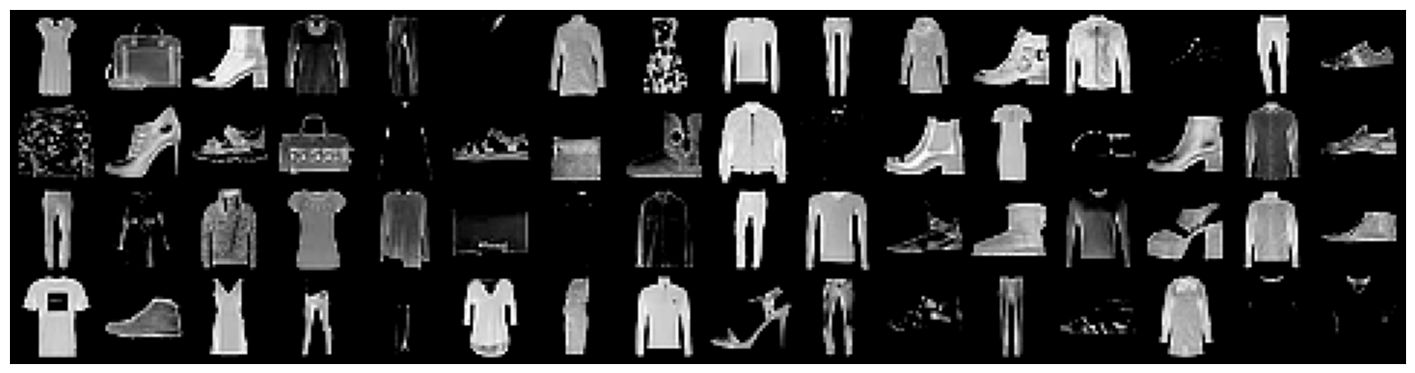

In [ ]:
for images, labels in data_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
    break

## - Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, generator_layer_size, z_size, img_size, class_num):
        super().__init__()

        self.z_size = z_size
        self.img_size = img_size

        self.label_emb = nn.Embedding(class_num, class_num)

        self.model = nn.Sequential(
            nn.Linear(self.z_size + class_num, generator_layer_size[0]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[0], generator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[1], generator_layer_size[2]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[2], self.img_size * self.img_size),
            nn.Tanh()
        )

    def forward(self, z, labels):

        # Reshape z
        z = z.view(-1, self.z_size)

        # One-hot vector to embedding vector
        c = self.label_emb(labels)

        # Concat image & label
        x = torch.cat([z, c], 1)

        # Generator out
        out = self.model(x)

        return out.view(-1, self.img_size, self.img_size)

## - Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, discriminator_layer_size, img_size, class_num):
        super().__init__()

        self.label_emb = nn.Embedding(class_num, class_num)
        self.img_size = img_size

        self.model = nn.Sequential(
            nn.Linear(self.img_size * self.img_size + class_num, discriminator_layer_size[0]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[0], discriminator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[1], discriminator_layer_size[2]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[2], 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):

        # Reshape fake image
        x = x.view(-1, self.img_size * self.img_size)

        # One-hot vector to embedding vector
        c = self.label_emb(labels)

        # Concat image & label
        x = torch.cat([x, c], 1)

        # Discriminator out
        out = self.model(x)

        return out.squeeze()

In [ ]:
# Define generator
generator = Generator(generator_layer_size, z_size, img_size, class_num).to(device)
# Define discriminator
discriminator = Discriminator(discriminator_layer_size, img_size, class_num).to(device)

## - Adversarial Learning of Generator & Discriminator

In [ ]:
# Loss function
criterion = nn.BCELoss()

In [ ]:
# Optimizer
g_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

In [ ]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):

    # Init gradient
    g_optimizer.zero_grad()

    # Building z
    z = Variable(torch.randn(batch_size, z_size)).to(device)

    # Building fake labels
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)

    # Generating fake images
    fake_images = generator(z, fake_labels)

    # Disciminating fake images
    validity = discriminator(fake_images, fake_labels)

    # Calculating discrimination loss (fake images)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).to(device))

    # Backword propagation
    g_loss.backward()

    #  Optimizing generator
    g_optimizer.step()

    return g_loss.data

In [ ]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):

    # Init gradient
    d_optimizer.zero_grad()

    # Disciminating real images
    real_validity = discriminator(real_images, labels)

    # Calculating discrimination loss (real images)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).to(device))

    # Building z
    z = Variable(torch.randn(batch_size, z_size)).to(device)

    # Building fake labels
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)

    # Generating fake images
    fake_images = generator(z, fake_labels)

    # Disciminating fake images
    fake_validity = discriminator(fake_images, fake_labels)

    # Calculating discrimination loss (fake images)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).to(device))

    # Sum two losses
    d_loss = real_loss + fake_loss

    # Backword propagation
    d_loss.backward()

    # Optimizing discriminator
    d_optimizer.step()

    return d_loss.data

Starting epoch 1...
g_loss: 2.6330747604370117, d_loss: 0.31803157925605774


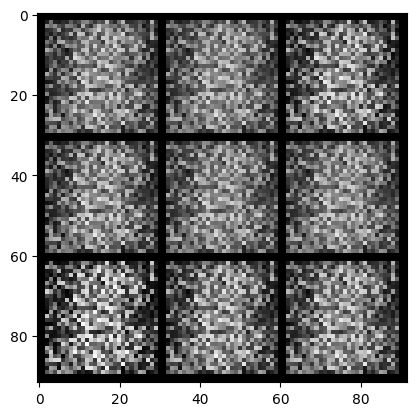

Starting epoch 2...
g_loss: 4.780367374420166, d_loss: 0.5170053839683533


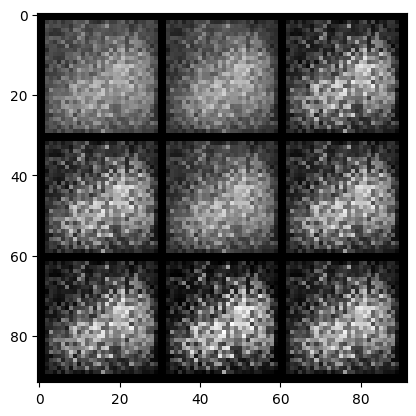

Starting epoch 3...
g_loss: 3.663257122039795, d_loss: 0.24538584053516388


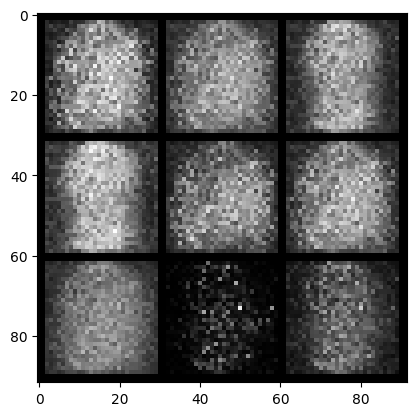

Starting epoch 4...
g_loss: 3.03210711479187, d_loss: 0.08095686137676239


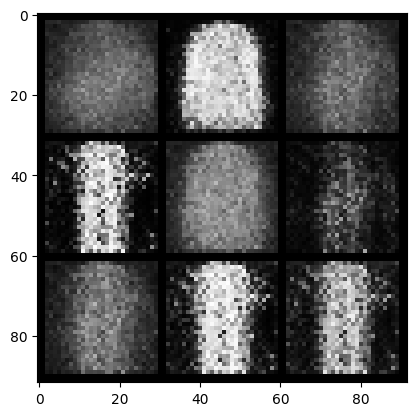

Starting epoch 5...
g_loss: 3.343330144882202, d_loss: 0.15356944501399994


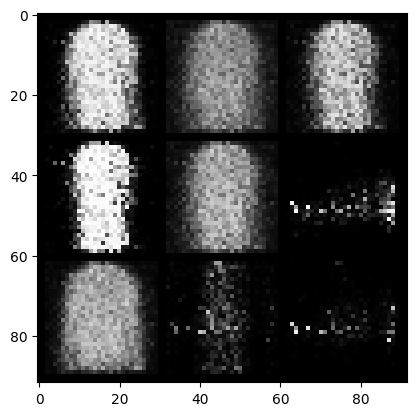

Starting epoch 6...
g_loss: 3.5909295082092285, d_loss: 0.136826291680336


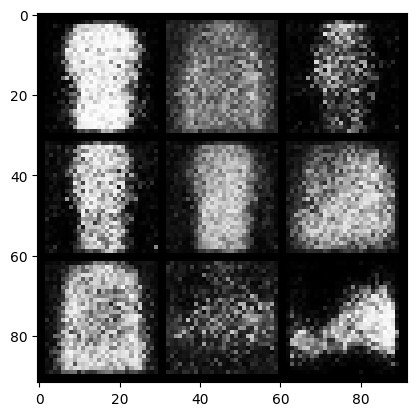

Starting epoch 7...
g_loss: 3.8928654193878174, d_loss: 0.27476727962493896


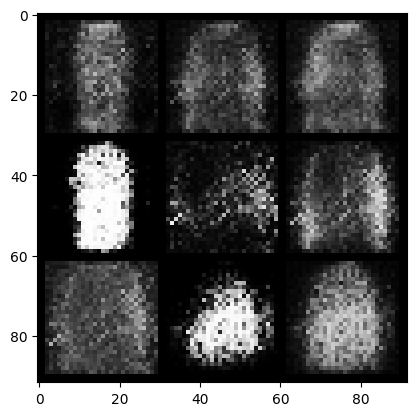

Starting epoch 8...
g_loss: 2.5799036026000977, d_loss: 0.435676634311676


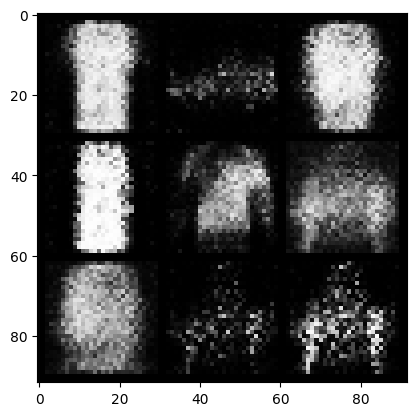

Starting epoch 9...
g_loss: 2.5961191654205322, d_loss: 0.5215667486190796


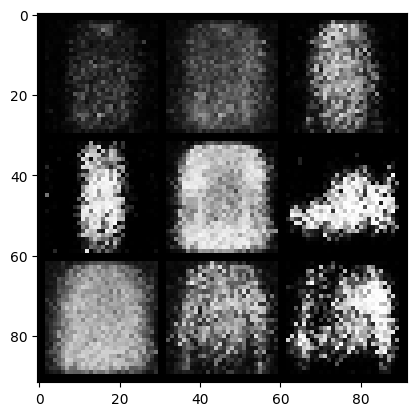

Starting epoch 10...
g_loss: 2.5508921146392822, d_loss: 0.1554434895515442


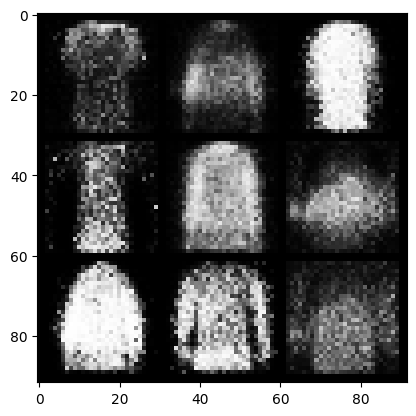

Starting epoch 11...
g_loss: 2.0313992500305176, d_loss: 0.4480305314064026


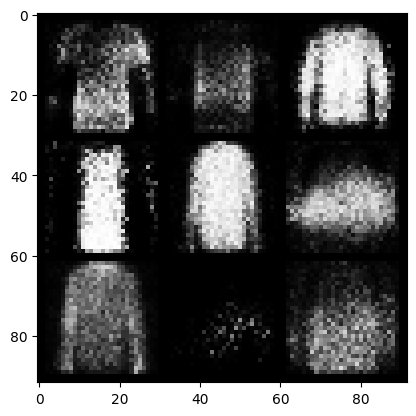

Starting epoch 12...
g_loss: 2.803443670272827, d_loss: 1.124423623085022


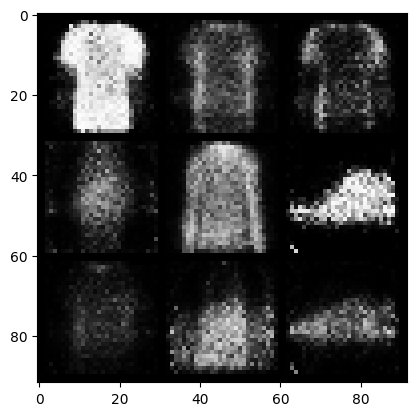

Starting epoch 13...
g_loss: 2.600499391555786, d_loss: 0.674963116645813


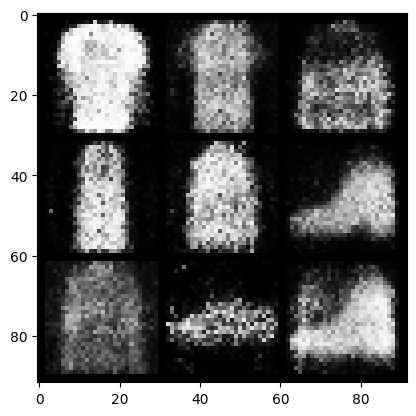

Starting epoch 14...
g_loss: 2.1940524578094482, d_loss: 0.2939176559448242


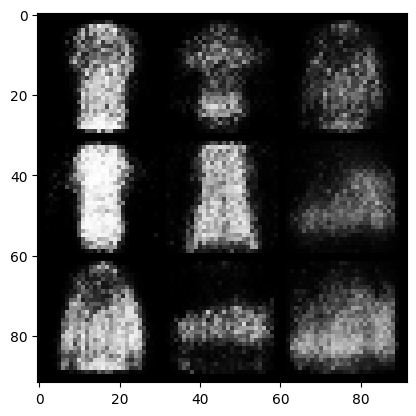

Starting epoch 15...
g_loss: 2.1753592491149902, d_loss: 0.8350310921669006


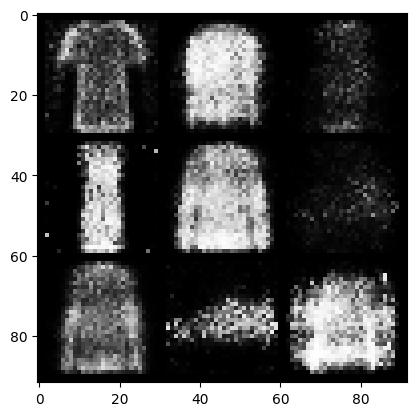

Starting epoch 16...
g_loss: 2.0594382286071777, d_loss: 0.4923515021800995


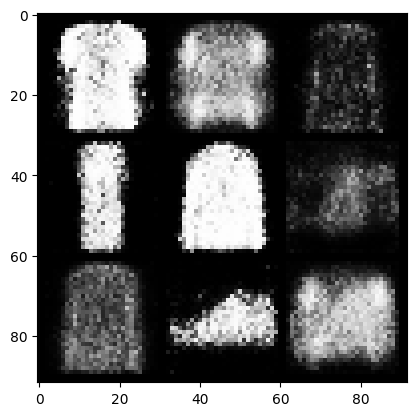

Starting epoch 17...
g_loss: 1.7257139682769775, d_loss: 0.8386932611465454


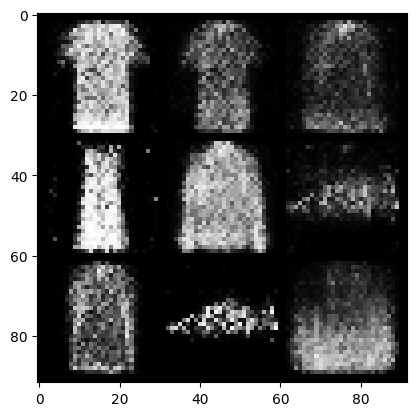

Starting epoch 18...
g_loss: 2.298593759536743, d_loss: 1.0398701429367065


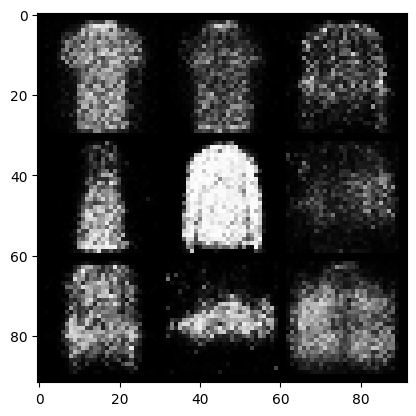

Starting epoch 19...
g_loss: 1.9611129760742188, d_loss: 0.4569016098976135


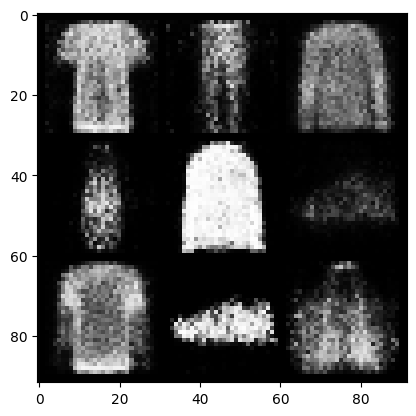

Starting epoch 20...
g_loss: 1.6782622337341309, d_loss: 0.7341367602348328


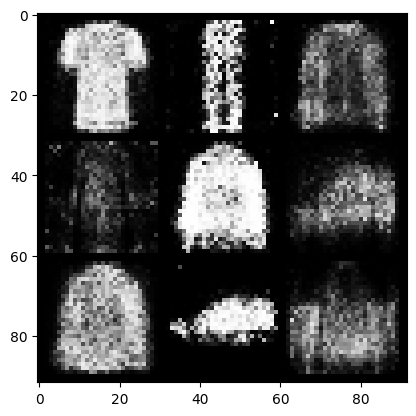

Starting epoch 21...
g_loss: 1.9503462314605713, d_loss: 0.5367176532745361


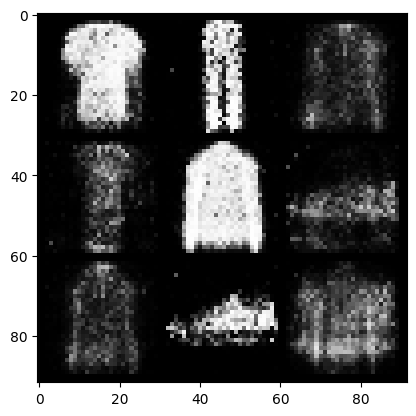

Starting epoch 22...
g_loss: 2.0525949001312256, d_loss: 0.9301957488059998


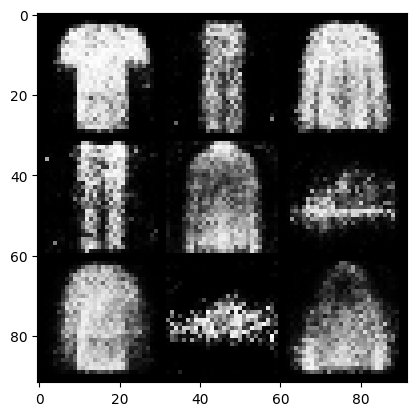

Starting epoch 23...
g_loss: 2.026885509490967, d_loss: 0.7157506346702576


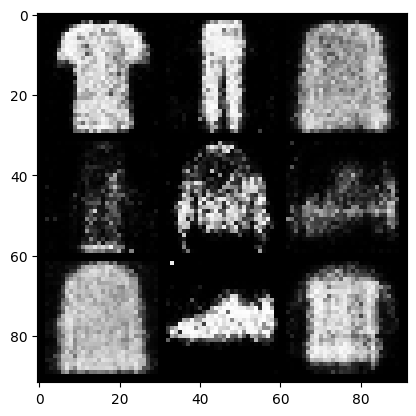

Starting epoch 24...
g_loss: 1.7011146545410156, d_loss: 0.37962841987609863


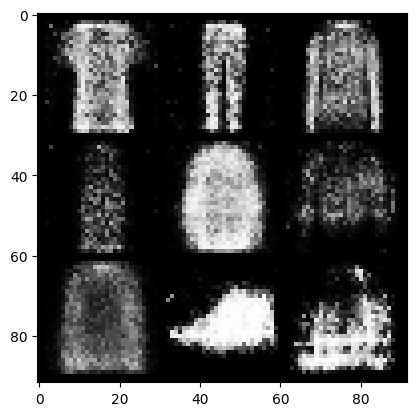

Starting epoch 25...
g_loss: 1.906983733177185, d_loss: 0.7825157642364502


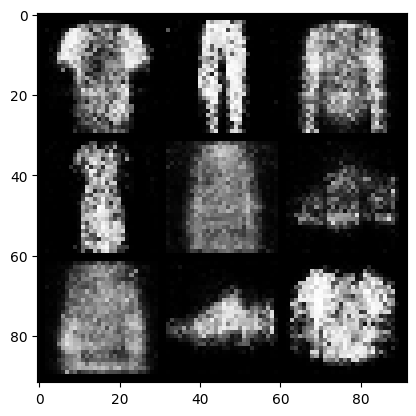

Starting epoch 26...
g_loss: 1.7561246156692505, d_loss: 0.8351709246635437


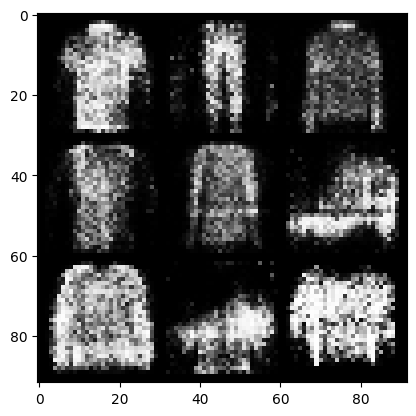

Starting epoch 27...
g_loss: 1.973131537437439, d_loss: 0.7753878831863403


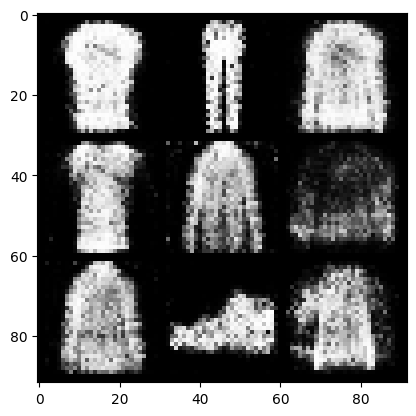

Starting epoch 28...
g_loss: 1.8125804662704468, d_loss: 1.071770191192627


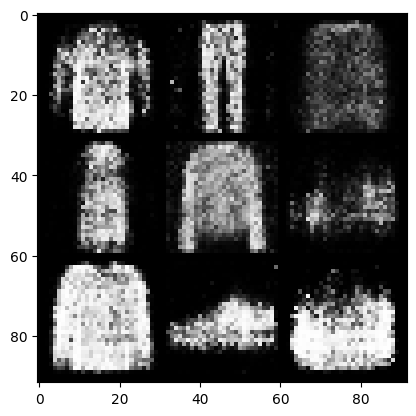

Starting epoch 29...
g_loss: 2.0016188621520996, d_loss: 0.5810335874557495


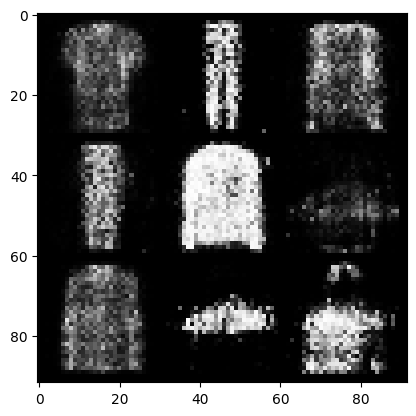

Starting epoch 30...
g_loss: 1.6367201805114746, d_loss: 0.86887526512146


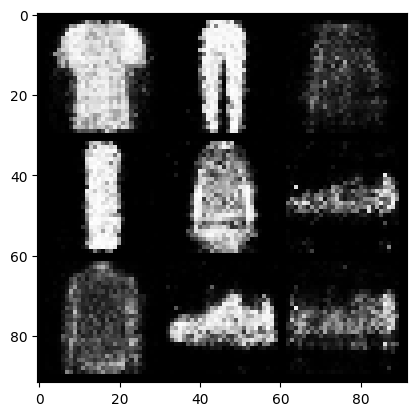

In [ ]:
for epoch in range(epochs):

    print('Starting epoch {}...'.format(epoch+1))

    for i, (images, labels) in enumerate(data_loader):

        # Train data
        real_images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        # Set generator train
        generator.train()

        # Train discriminator
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)

        # Train generator
        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)

    # Set generator eval
    generator.eval()

    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))

    # Building z
    z = Variable(torch.randn(class_num-1, z_size)).to(device)

    # Labels 0 ~ 8
    labels = Variable(torch.LongTensor(np.arange(class_num-1))).to(device)

    # Generating images
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()

    # Show images
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()

## - Show Generating Images

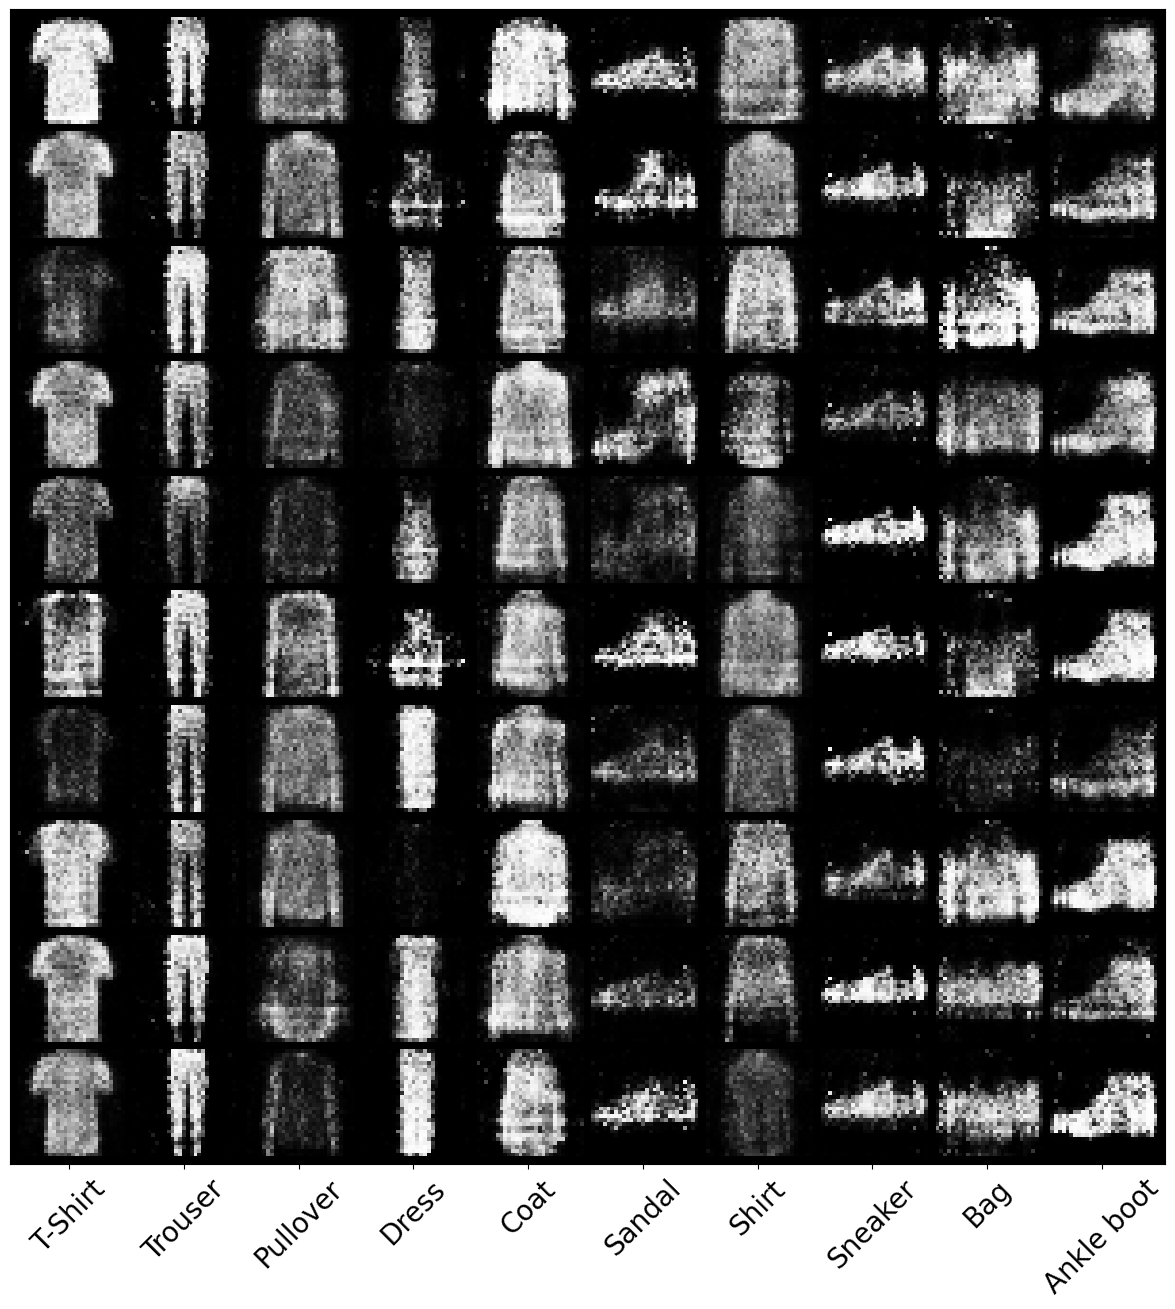

In [ ]:
# Building z
z = Variable(torch.randn(z_size, z_size)).to(device)

# Labels 0 ~ 9
labels = Variable(torch.LongTensor([i for _ in range(class_num) for i in range(class_num)])).to(device)

# Generating images
sample_images = generator(z, labels).unsqueeze(1).data.cpu()

# Show images
grid = make_grid(sample_images, nrow=class_num, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(grid)
_ = plt.yticks([])
_ = plt.xticks(np.arange(15, 300, 30), class_list, rotation=45, fontsize=20)